## HW7: Opacity

In [1]:
import sa
import numpy as np
import matplotlib.pyplot as plt
import math
from astropy import units as u
from astropy import constants as const

In [2]:
a0 = 1.0443*10**(-26) # with wavelength in angstroms
R = 1.09678*10**(-3) #per angstrom
Rcm = 1.09678*10**(5) #per cm
loge = .43429
h = const.h.cgs.value
e = const.e.gauss.value
me = const.m_e.value
pi = np.pi
c = const.c.cgs.value

In [3]:
def alpha_H_bf(wl,n): # wl is wavelength
    return a0*g_bf(wl,n)*(wl**3)*(n**(-5))
    # returns units of cm2/nuetral hydrogen absorber

In [4]:
def g_bf(wl,n):
    first  = np.ones(wl.size)
    second = .3456/((wl*R)**(1/3))
    third  = ((wl*R)/(n**2))-(.5)
    return first-(second*third)

In [5]:
def k_H_bf(wl,temp,Pe):
    ones = np.ones(wl.size)
    n0 = np.floor(np.sqrt(wl*R)+ones)
    #print("n0 is"+str(n0))
    I = sa.X('H')
    b3 = I*(ones-(1/(n0+3)**2))
    theta = sa.temptotheta(temp)

    Sigma = 0
    for x in range(3):
        n = n0 + x
        Sigma += (g_bf(wl,n)/(n**3))*np.power(10,-theta*H_X(n))
    
    second = (loge/(2*theta*I))*(np.power(10,-b3*theta)-np.power(10,-I*theta))
    
    return a0*(wl**3)*(Sigma+second)

In [6]:
def H_X(n):
    return 13.598*(np.ones(n.size)-(1/(n**2)))

In [7]:
def alpha_H_ff(wl,temp):
    wlcm=wl*10**(-8)
    num = 2*h**2*e**2*Rcm*wlcm**3*(2*me)**(1/2)
    den = 3**(3/2)*pi*me**3*c**3*(pi*k*temp)**(1/2)
    return num/den
    # in cm^2 per absorber per electron?

In [8]:
def g_ff(wl,temp):
    theta = sa.temptotheta(temp)
    ones = np.ones(wl.size)
    chi_wl = (1.2398*10**4)/wl
    return ones+((.3456/(wl*R)**(1/3))*((loge/(theta*chi_wl))+.5))
    

In [9]:
def k_H_ff(wl,temp,Pe):
    I = sa.X('H')
    theta = sa.temptotheta(temp)
    return a0*wl**3*g_ff(wl,temp)*(loge/(2*theta*I))*np.power(10,-theta*I)

In [25]:
def alpha_H_neg_bf(wl):
    a = np.zeros(7)
    a[0]=.1199654
    a[1]=-1.18267*10**(-6)
    a[2]=2.64243*10**(-7)
    a[3]=-4.40524*10**(-11)
    a[4]=3.23992*10**(-15)
    a[5]=-1.39568*10**(-19)
    a[6]=2.78701*10**(-24)
    sum=np.zeros(wl.size)
    for x in range(7):
        sum+=a[x]*np.power(wl,x)
    final = np.zeros(wl.size)
    for x in range(wl.size):
        if wl[x]<16110:
            final[x]=sum[x]
    
    return final*10**(-17)
    

In [11]:
def k_H_neg_bf(wl,temp,Pe):
    theta = sa.temptotheta(temp)
    return (4.158*10**(-10))*alpha_H_neg_bf(wl)*Pe*theta**(5/2)*np.power(10,.754*theta)

In [12]:
def k_H_neg_ff(wl,temp,Pe):
    lwl=np.log10(wl)
    theta = sa.temptotheta(temp)
    log_theta =  np.log10(theta)
    f0 = -2.2763-1.685*lwl+.76661*lwl**2-.0533464*lwl**3
    f1 = 15.2827-9.2846*lwl+1.99381*lwl**2-.142631*lwl**3
    f2 = -197.789+190.266*lwl-67.9775*lwl**2+10.6913*lwl**3-.625151*lwl**4
    return 10**(-26)*Pe*np.power(10,f0+f1*log_theta+f2*log_theta**2)

In [13]:
def k_tot(wl,temp,Pe):
    kbf   = k_H_bf(wl,temp,Pe)
    kff   = k_H_ff(wl,temp,Pe)
    knbf  = k_H_neg_bf(wl,temp,Pe)
    knff  = k_H_neg_ff(wl,temp,Pe)

    Phi    = sa.Phi(temp,'H')
    chi_wl = (1.2398*10**4)/wl
    theta  = sa.temptotheta(temp)
    ktot = np.zeros([5,wl.size])
    factor1  = (1-np.power(10,-chi_wl*theta))
    factor2 = (1/(1+(Phi/Pe)))
    ktot[0] = ((kbf+kff+knbf)*factor1 + knff)#*factor2
    ktot[1] = kbf*factor1 #*factor2
    ktot[2] = kff*factor1 #*factor2
    ktot[3] = knbf*factor1#*factor2
    ktot[4] = knff#*factor2
    #return ((kbf+kff+knbf)*(1-np.power(10,-chi_wl*theta)) + knff)*(1/(1+(Phi/Pe)))
    return ktot

In [14]:
def k_nu(wl,temp,Pe):
    sig = 2*10**(-24)
    return k_tot(wl,temp,Pe)/sig

In [15]:
sa.load_partition_data()
sa.load_ionization_data()

/home/crobles/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


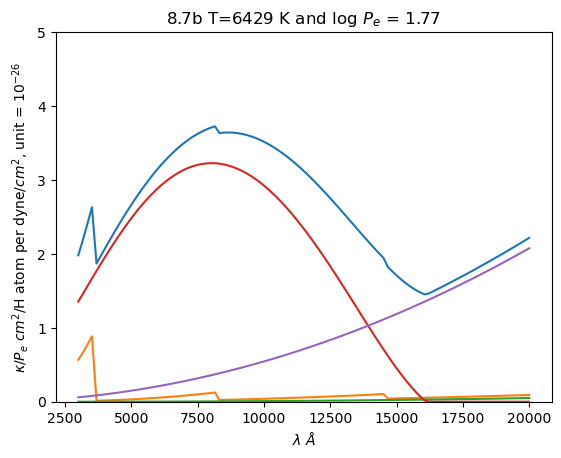

In [27]:
wl = np.linspace(3000,20000,num=100)
temp = 6429
Pe = 10**(1.77)
thing=(k_tot(wl,temp,Pe)/Pe)*10**(26)
plt.plot(wl,thing[0])
plt.plot(wl,thing[1])
plt.plot(wl,thing[2])
plt.plot(wl,thing[3])
plt.plot(wl,thing[4])
plt.title("8.7b T=6429 K and log $P_e$ = 1.77")
plt.ylabel(r"$\kappa/P_e$ $cm^2$/H atom per dyne/$cm^2$, unit = $10^{-26}$")
plt.xlabel(r"$\lambda\ \AA$")
plt.ylim([0,5])
plt.savefig('hw7_1.svg', bbox_inches='tight')
plt.show()

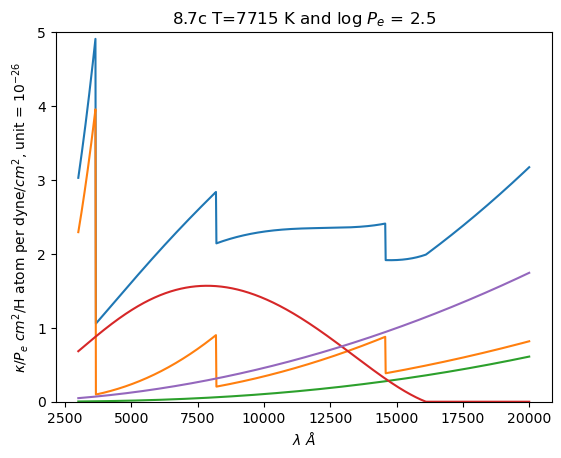

In [28]:
wl = np.linspace(3000,20000,num=1000)
temp = 7715
Pe = 10**(2.5)

thing=(k_tot(wl,temp,Pe)/Pe)*10**(26)
plt.plot(wl,thing[0])
plt.plot(wl,thing[1])
plt.plot(wl,thing[2])
plt.plot(wl,thing[3])
plt.plot(wl,thing[4])
plt.title("8.7c T=7715 K and log $P_e$ = 2.5")
plt.ylabel(r"$\kappa/P_e$ $cm^2$/H atom per dyne/$cm^2$, unit = $10^{-26}$")
plt.xlabel(r"$\lambda\ \AA$")
plt.ylim([0,5])
plt.savefig('hw7_2.svg', bbox_inches='tight')
plt.show()

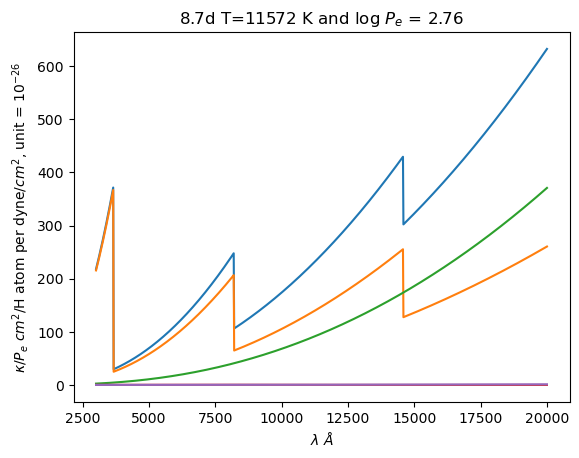

In [29]:
wl = np.linspace(3000,20000,num=1000)
temp = 11572
Pe = 10**(2.76)

thing=(k_tot(wl,temp,Pe)/Pe)*10**(26)
plt.plot(wl,thing[0])
plt.plot(wl,thing[1])
plt.plot(wl,thing[2])
plt.plot(wl,thing[3])
plt.plot(wl,thing[4])
plt.title("8.7d")
plt.title("8.7d T=11572 K and log $P_e$ = 2.76")
plt.ylabel(r"$\kappa/P_e$ $cm^2$/H atom per dyne/$cm^2$, unit = $10^{-26}$")
plt.xlabel(r"$\lambda\ \AA$")
#plt.ylim([0,700])
plt.savefig('hw7_3.svg', bbox_inches='tight')
plt.show()

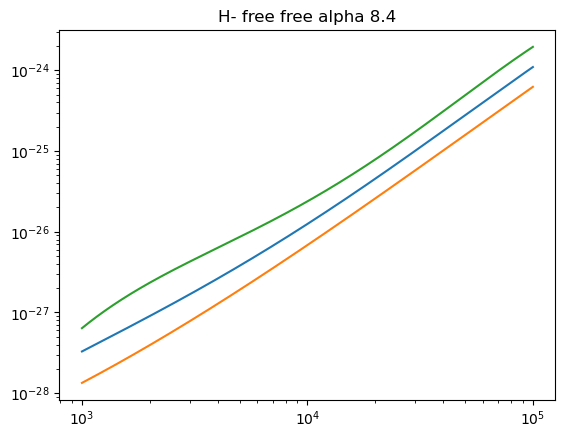

In [19]:
wl = np.logspace(3,5,num=1000)
temp=5040
Pe=10

plt.plot(wl,k_H_neg_ff(wl,2520,Pe)/Pe)
plt.plot(wl,k_H_neg_ff(wl,temp,Pe)/Pe)
plt.plot(wl,k_H_neg_ff(wl,1080,Pe)/Pe)
plt.title("H- free free alpha 8.4")
plt.yscale("log")
plt.xscale("log")
plt.show()

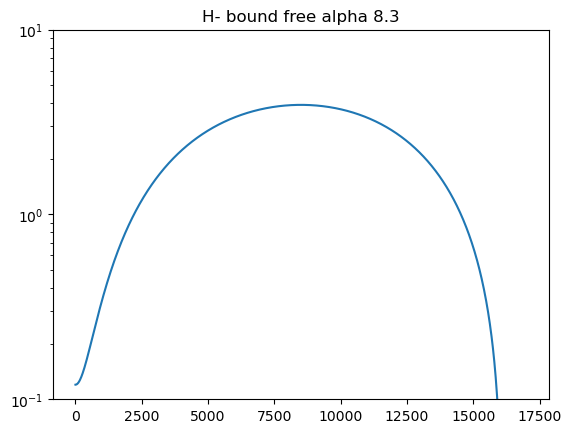

In [26]:
wl = np.linspace(1,17000,num=1000)
alpha_H_neg_bf(wl)
plt.plot(wl,alpha_H_neg_bf(wl)*10**(17))
plt.title("H- bound free alpha 8.3")
plt.yscale("log")
plt.ylim([.1,10])
plt.show()

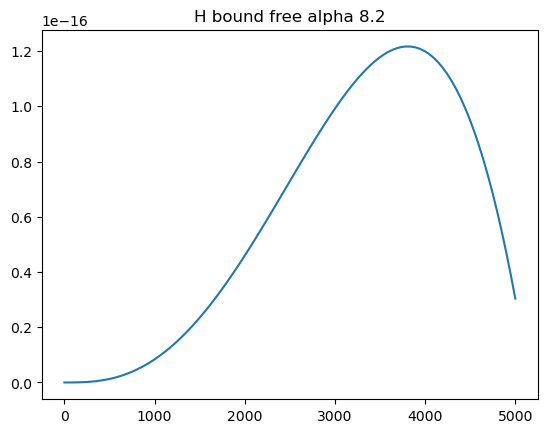

In [21]:


wl = np.linspace(1,5000,num=100)


plt.plot(wl,alpha_H_bf(wl,1))
#plt.plot(wl,alpha_H_bf(wl,2))
#plt.plot(wl,alpha_H_bf(wl,3))
plt.title("H bound free alpha 8.2")

plt.show()